In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

# Configuraciones para visualización
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Ignorar advertencias futuras para mantener la salida limpia
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning) # Para advertencias de Seaborn sobre distribuciones

# Sprint 12 - Proyecto de Predicción de Recuperación de Oro

## Introducción
En este proyecto, construiremos un modelo de machine learning para predecir la cantidad de oro recuperado del mineral de oro. Los datos se dividen en tres etapas principales de purificación. El objetivo es optimizar la producción y eliminar parámetros no rentables.

## 1. Preparación de los Datos

### 1.1. Abrir los archivos y examinar los datos
Cargaremos los tres datasets proporcionados: entrenamiento, prueba y completo.

In [6]:
# Rutas de acceso a los archivos (ajustar si es necesario)
path_train = 'gold_recovery_train.csv'
path_test = 'gold_recovery_test.csv'
path_full = 'gold_recovery_full.csv'

# Cargar los datasets
try:
    df_train = pd.read_csv(path_train, parse_dates=['date'], index_col='date')
    df_test = pd.read_csv(path_test, parse_dates=['date'], index_col='date')
    df_full = pd.read_csv(path_full, parse_dates=['date'], index_col='date')
except FileNotFoundError:
    print("Error: Uno o más archivos no se encontraron. Asegúrate de que las rutas son correctas.")
    # Placeholder DataFrames para evitar errores posteriores si los archivos no se cargan
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    df_full = pd.DataFrame()

if not df_train.empty:
    print("--- Información del Dataset de Entrenamiento ---")
    df_train.info()
    print("\n--- Primeras 5 filas del Dataset de Entrenamiento ---")
    print(df_train.head())
    print("\n--- Estadísticas Descriptivas del Dataset de Entrenamiento ---")
    print(df_train.describe())

    print("\n\n--- Información del Dataset de Prueba ---")
    df_test.info()
    print("\n--- Primeras 5 filas del Dataset de Prueba ---")
    print(df_test.head())
    print("\n--- Estadísticas Descriptivas del Dataset de Prueba ---")
    print(df_test.describe())

    print("\n\n--- Información del Dataset Completo ---")
    df_full.info()
    print("\n--- Primeras 5 filas del Dataset Completo ---")
    print(df_full.head())
    print("\n--- Estadísticas Descriptivas del Dataset Completo ---")
    print(df_full.describe())
else:
    print("No se pudieron cargar los datos. El análisis no puede continuar.")

--- Información del Dataset de Entrenamiento ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float

### 1.2. Comprueba que el cálculo de la recuperación (`rougher.output.recovery`) sea correcto.
La fórmula de recuperación es:
$$ \text{Recovery} = \frac{C \times (F - T)}{F \times (C - T)} \times 100\% $$
Donde:
- $C$: Proporción de oro en el concentrado después de la flotación (o después de la limpieza primaria).
- $F$: Proporción de oro en la alimentación antes de la flotación (o antes de la limpieza primaria).
- $T$: Proporción de oro en las colas después de la flotación (o después de la limpieza primaria).

Calcularemos la recuperación para `rougher.output.recovery` usando las columnas del dataset de entrenamiento:
- $C = \text{rougher.output.concentrate_au}$
- $F = \text{rougher.input.feed_au}$
- $T = \text{rougher.output.tail_au}$

In [7]:
if not df_train.empty:
    # Seleccionar las columnas necesarias para el cálculo
    C = df_train['rougher.output.concentrate_au']
    F = df_train['rougher.input.feed_au']
    T = df_train['rougher.output.tail_au']
    
    # Calcular la recuperación
    # Manejar posibles divisiones por cero o valores infinitos reemplazándolos por NaN
    numerator = C * (F - T)
    denominator = F * (C - T)
    
    calculated_recovery = (numerator / denominator) * 100
    
    # Reemplazar infinitos y NaN (si F o (C-T) es cero) con NaN para un MAE justo
    calculated_recovery.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Comparar con la columna 'rougher.output.recovery'
    actual_recovery = df_train['rougher.output.recovery']
    
    # Crear un DataFrame temporal para alinear y eliminar NaNs para el cálculo del MAE
    comparison_df = pd.DataFrame({
        'calculated': calculated_recovery,
        'actual': actual_recovery
    }).dropna()
    
    # Calcular el Error Absoluto Medio (MAE)
    mae_recovery = mean_absolute_error(comparison_df['actual'], comparison_df['calculated'])
    
    print(f"MAE entre la recuperación calculada y los valores de la característica 'rougher.output.recovery': {mae_recovery:.10f}")

    if mae_recovery < 1e-9: # Un umbral muy pequeño para considerar que son "iguales"
        print("\nEl MAE es extremadamente bajo, lo que sugiere que el cálculo de recuperación proporcionado es correcto.")
    else:
        print("\nEl MAE es significativo. Puede haber diferencias en el cálculo o en los datos.")
        
    # Mostrar algunas filas para inspección visual
    print("\nComparación de valores (primeras 10 filas con datos válidos):")
    print(comparison_df.head(10))
else:
    print("Dataset de entrenamiento vacío. No se puede verificar la recuperación.")

MAE entre la recuperación calculada y los valores de la característica 'rougher.output.recovery': 0.0000000000

El MAE es extremadamente bajo, lo que sugiere que el cálculo de recuperación proporcionado es correcto.

Comparación de valores (primeras 10 filas con datos válidos):
                     calculated     actual
date                                      
2016-01-15 00:00:00   87.107763  87.107763
2016-01-15 01:00:00   86.843261  86.843261
2016-01-15 02:00:00   86.842308  86.842308
2016-01-15 03:00:00   87.226430  87.226430
2016-01-15 04:00:00   86.688794  86.688794
2016-01-15 05:00:00   88.156912  88.156912
2016-01-15 06:00:00   88.168065  88.168065
2016-01-15 07:00:00   87.668336  87.668336
2016-01-15 08:00:00   87.035862  87.035862
2016-01-15 09:00:00   87.650868  87.650868


### 1.3. Analiza las características no disponibles en el conjunto de prueba.
Compararemos las columnas del conjunto de entrenamiento y prueba para identificar las que faltan en el de prueba.

In [8]:
if not df_train.empty and not df_test.empty:
    train_cols = set(df_train.columns)
    test_cols = set(df_test.columns)
    
    missing_in_test = list(train_cols - test_cols)
    
    print(f"Número de características en el conjunto de entrenamiento: {len(train_cols)}")
    print(f"Número de características en el conjunto de prueba: {len(test_cols)}")
    print(f"Número de características faltantes en el conjunto de prueba: {len(missing_in_test)}")
    
    print("\nCaracterísticas faltantes en el conjunto de prueba y sus tipos (del conjunto de entrenamiento):")
    missing_features_info = []
    if missing_in_test:
        for col in sorted(missing_in_test):
            missing_features_info.append({'Feature': col, 'DataType': df_train[col].dtype})
        print(pd.DataFrame(missing_features_info))
    else:
        print("No hay características faltantes en el conjunto de prueba.")

    print("\nAnálisis:")
    print("Las características faltantes en el conjunto de prueba parecen ser principalmente parámetros de 'output' y algunos parámetros de 'calculation'.")
    print("Esto es esperado, ya que estos valores a menudo se miden o calculan después del proceso y no estarían disponibles en tiempo real para una predicción.")
    print("Las variables objetivo ('rougher.output.recovery' y 'final.output.recovery') también están ausentes en el conjunto de prueba, como se esperaba.")
else:
    print("Datasets de entrenamiento o prueba vacíos. No se pueden comparar columnas.")

Número de características en el conjunto de entrenamiento: 86
Número de características en el conjunto de prueba: 52
Número de características faltantes en el conjunto de prueba: 34

Características faltantes en el conjunto de prueba y sus tipos (del conjunto de entrenamiento):
                                              Feature DataType
0                         final.output.concentrate_ag  float64
1                         final.output.concentrate_au  float64
2                         final.output.concentrate_pb  float64
3                        final.output.concentrate_sol  float64
4                               final.output.recovery  float64
5                                final.output.tail_ag  float64
6                                final.output.tail_au  float64
7                                final.output.tail_pb  float64
8                               final.output.tail_sol  float64
9               primary_cleaner.output.concentrate_ag  float64
10              primary_clea

### 1.4. Realiza el preprocesamiento de datos.
Los datos se indexan con la fecha y hora. Los parámetros cercanos en el tiempo suelen ser similares, por lo que el método `ffill` (forward fill) es adecuado para manejar los valores ausentes.

In [9]:
if not df_train.empty and not df_test.empty and not df_full.empty:
    print("Valores ausentes antes del preprocesamiento (entrenamiento):")
    print(df_train.isnull().sum().sort_values(ascending=False).head(10))
    print("\nValores ausentes antes del preprocesamiento (prueba):")
    print(df_test.isnull().sum().sort_values(ascending=False).head(10))
    print("\nValores ausentes antes del preprocesamiento (completo):")
    print(df_full.isnull().sum().sort_values(ascending=False).head(10))

    # Aplicar ffill a todos los datasets
    # Es importante rellenar ANTES de cualquier otra operación que pueda depender de datos completos
    df_train_processed = df_train.fillna(method='ffill')
    df_test_processed = df_test.fillna(method='ffill')
    df_full_processed = df_full.fillna(method='ffill')

    # Verificar si quedan NaNs después de ffill (podría haber NaNs al inicio de las series)
    # Si es así, podríamos usar bfill o eliminar esas filas si son pocas
    df_train_processed = df_train_processed.fillna(method='bfill')
    df_test_processed = df_test_processed.fillna(method='bfill')
    df_full_processed = df_full_processed.fillna(method='bfill')
    
    print("\nValores ausentes DESPUÉS del preprocesamiento (entrenamiento):")
    print(df_train_processed.isnull().sum().sum())
    print("Valores ausentes DESPUÉS del preprocesamiento (prueba):")
    print(df_test_processed.isnull().sum().sum())
    print("Valores ausentes DESPUÉS del preprocesamiento (completo):")
    print(df_full_processed.isnull().sum().sum())

    # Asegurar que los tipos de datos sean numéricos donde se espera
    # Esto normalmente ya está bien si read_csv funcionó correctamente, pero es una buena práctica revisar
    # por si alguna columna fue interpretada como 'object' incorrectamente.
    # Por la salida de .info(), ya sabemos que son float64 o int64, lo cual es bueno.

    print("\nPreprocesamiento de datos (manejo de NaNs con ffill y bfill) completado.")
else:
    print("Uno o más datasets están vacíos. El preprocesamiento no puede continuar.")
    # Crear DataFrames vacíos para evitar errores si los originales no se cargaron
    df_train_processed = pd.DataFrame()
    df_test_processed = pd.DataFrame()
    df_full_processed = pd.DataFrame()

Valores ausentes antes del preprocesamiento (entrenamiento):
rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
rougher.input.floatbank11_xanthate    1904
final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
dtype: int64

Valores ausentes antes del preprocesamiento (prueba):
rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary

## 2. Analiza los datos

### 2.1. Observa cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.

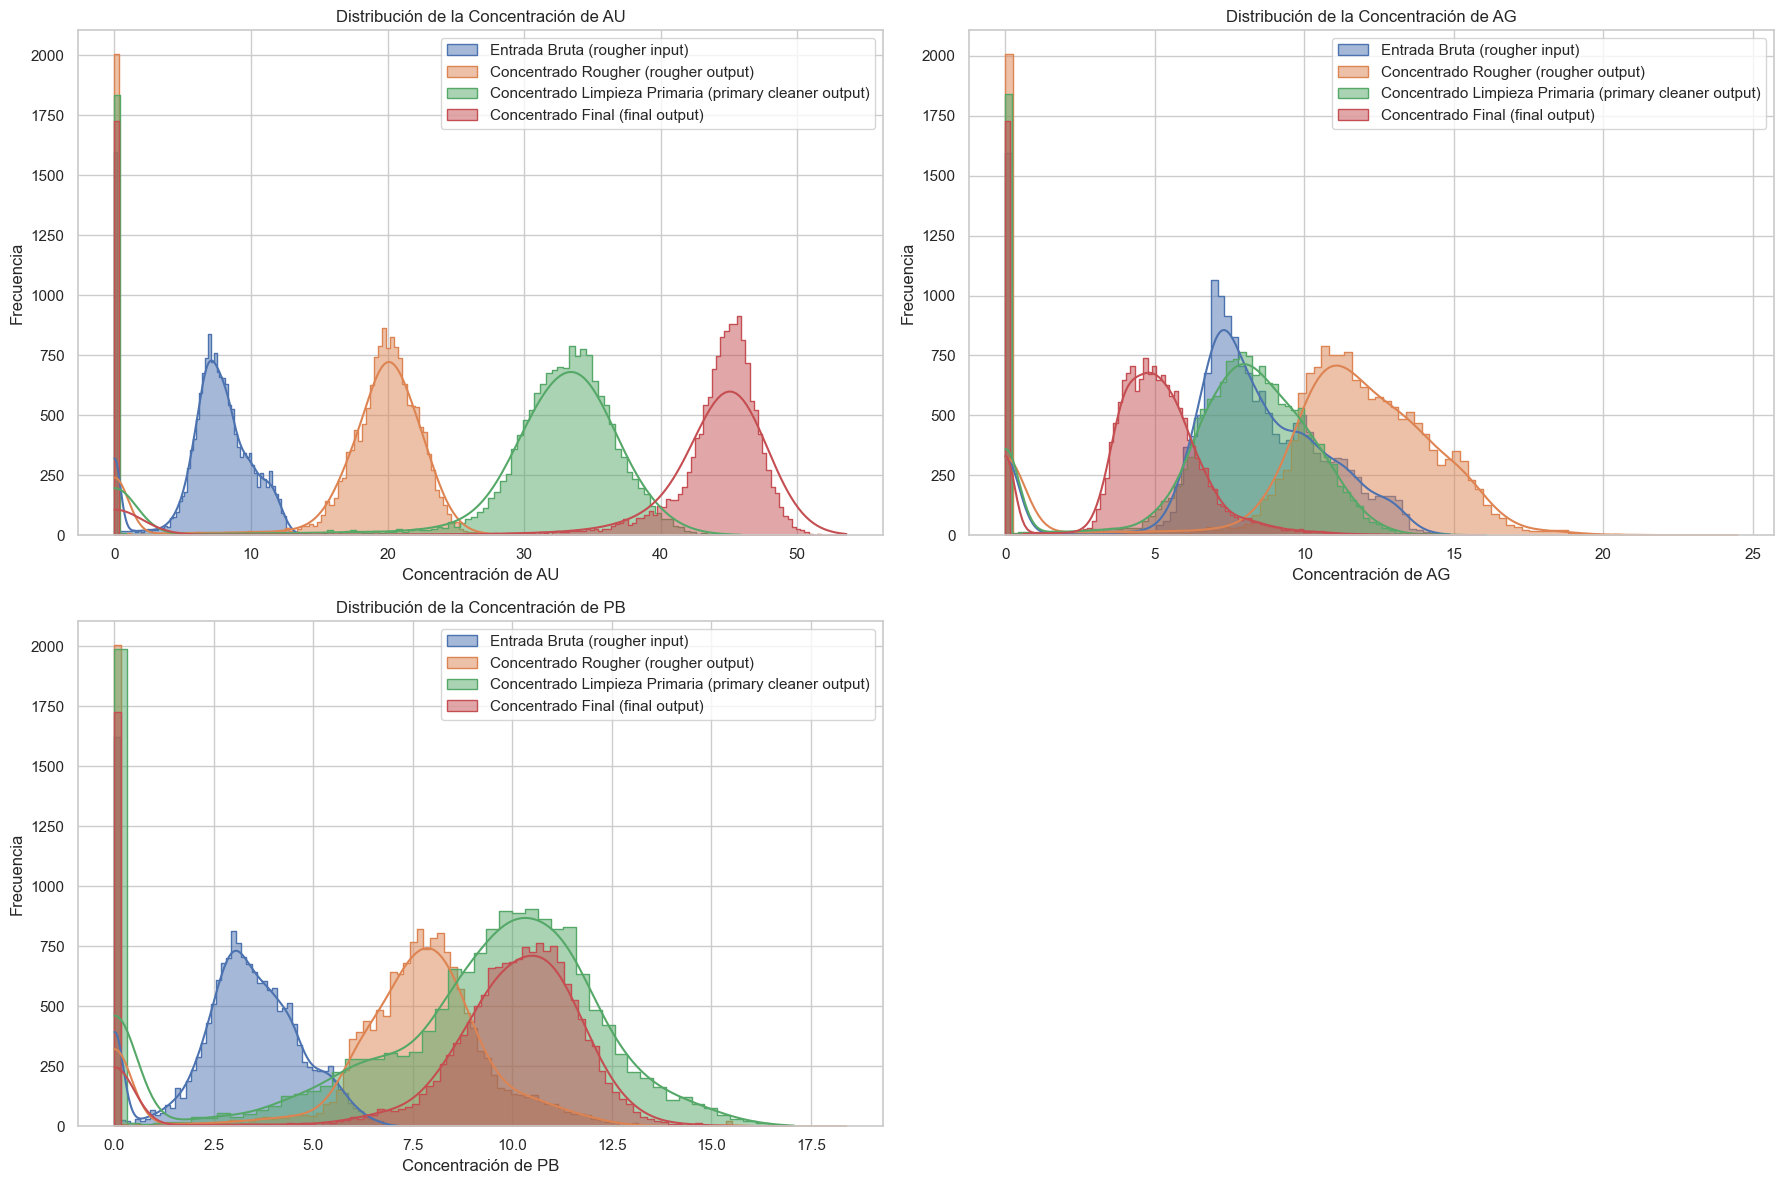

Análisis de Concentración de Metales:
- Oro (Au): La concentración de oro aumenta significativamente en cada etapa sucesiva de purificación, lo cual es el objetivo del proceso.
- Plata (Ag): La concentración de plata tiende a aumentar después de la etapa 'rougher', pero luego disminuye en las etapas finales de limpieza. Esto sugiere que la plata no es el metal principal que se busca concentrar al final.
- Plomo (Pb): La concentración de plomo parece aumentar a lo largo de las etapas, aunque no tanto como el oro. Es un subproducto común en la minería de oro.
- Se observan concentraciones cercanas a cero en algunas etapas, especialmente en la entrada bruta. Esto podría indicar mediciones erróneas o lotes de mineral muy pobres que podrían ser considerados atípicos.


In [10]:
if not df_train_processed.empty:
    metals = ['au', 'ag', 'pb']
    stages_feed = {
        'Entrada Bruta (rougher input)': 'rougher.input.feed_',
        'Concentrado Rougher (rougher output)': 'rougher.output.concentrate_',
        'Concentrado Limpieza Primaria (primary cleaner output)': 'primary_cleaner.output.concentrate_',
        'Concentrado Final (final output)': 'final.output.concentrate_'
    }

    plt.figure(figsize=(18, 12))
    plot_num = 1
    for metal in metals:
        plt.subplot(2, 2, plot_num)
        for stage_name, stage_prefix in stages_feed.items():
            col_name = stage_prefix + metal
            if col_name in df_train_processed.columns:
                sns.histplot(df_train_processed[col_name], label=stage_name, kde=True, element="step")
        plt.title(f'Distribución de la Concentración de {metal.upper()}')
        plt.xlabel(f'Concentración de {metal.upper()}')
        plt.ylabel('Frecuencia')
        plt.legend()
        plot_num += 1
    
    plt.tight_layout()
    plt.show()

    print("Análisis de Concentración de Metales:")
    print("- Oro (Au): La concentración de oro aumenta significativamente en cada etapa sucesiva de purificación, lo cual es el objetivo del proceso.")
    print("- Plata (Ag): La concentración de plata tiende a aumentar después de la etapa 'rougher', pero luego disminuye en las etapas finales de limpieza. Esto sugiere que la plata no es el metal principal que se busca concentrar al final.")
    print("- Plomo (Pb): La concentración de plomo parece aumentar a lo largo de las etapas, aunque no tanto como el oro. Es un subproducto común en la minería de oro.")
    print("- Se observan concentraciones cercanas a cero en algunas etapas, especialmente en la entrada bruta. Esto podría indicar mediciones erróneas o lotes de mineral muy pobres que podrían ser considerados atípicos.")
else:
    print("Dataset de entrenamiento procesado vacío. No se puede analizar la concentración de metales.")

### 2.2. Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba.
Usaremos la característica `rougher.input.feed_size`.

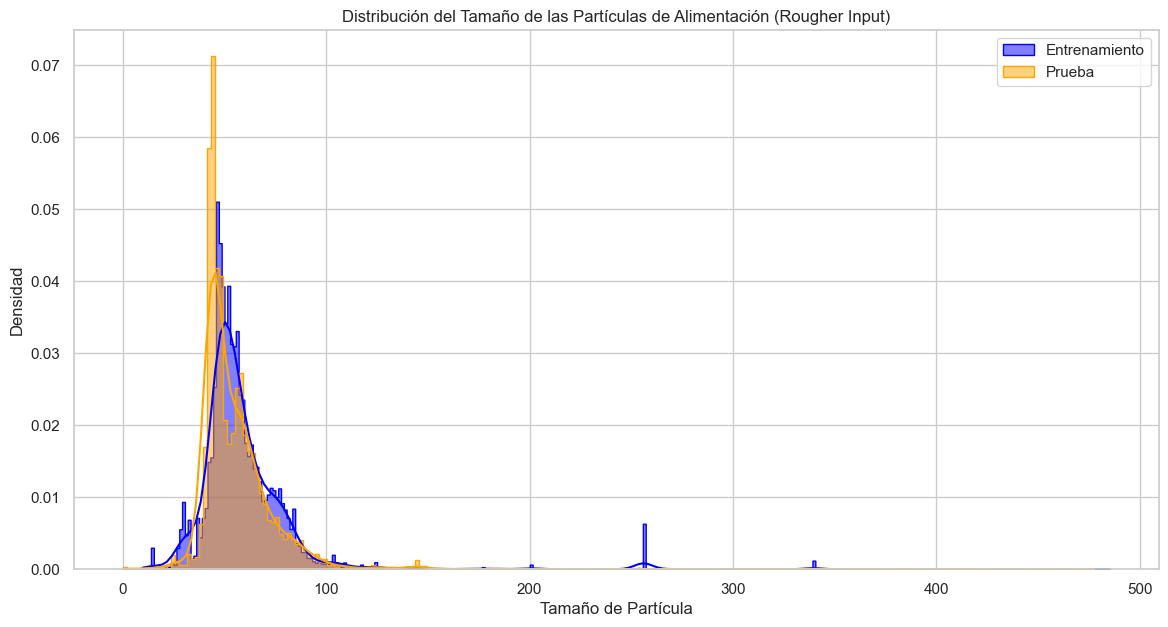

Análisis de Distribución del Tamaño de Partículas:
Las distribuciones del tamaño de las partículas de alimentación en los conjuntos de entrenamiento y prueba son bastante similares.
Ambos conjuntos muestran una distribución sesgada a la derecha, con la mayoría de las partículas en un rango de tamaño más pequeño, pero con una cola de partículas más grandes.
La similitud es buena, ya que indica que el modelo entrenado en el conjunto de entrenamiento debería generalizar bien al conjunto de prueba en términos de esta característica.

Estadísticas Descriptivas para 'rougher.input.feed_size':
Entrenamiento:
count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Prueba:
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477

In [11]:
if not df_train_processed.empty and not df_test_processed.empty:
    plt.figure(figsize=(14, 7))

    sns.histplot(df_train_processed['rougher.input.feed_size'], color='blue', label='Entrenamiento', kde=True, stat="density", element="step")
    sns.histplot(df_test_processed['rougher.input.feed_size'], color='orange', label='Prueba', kde=True, stat="density", element="step")

    plt.title('Distribución del Tamaño de las Partículas de Alimentación (Rougher Input)')
    plt.xlabel('Tamaño de Partícula')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()

    print("Análisis de Distribución del Tamaño de Partículas:")
    print("Las distribuciones del tamaño de las partículas de alimentación en los conjuntos de entrenamiento y prueba son bastante similares.")
    print("Ambos conjuntos muestran una distribución sesgada a la derecha, con la mayoría de las partículas en un rango de tamaño más pequeño, pero con una cola de partículas más grandes.")
    print("La similitud es buena, ya que indica que el modelo entrenado en el conjunto de entrenamiento debería generalizar bien al conjunto de prueba en términos de esta característica.")
    
    # Estadísticas descriptivas para una comparación más detallada
    print("\nEstadísticas Descriptivas para 'rougher.input.feed_size':")
    print("Entrenamiento:")
    print(df_train_processed['rougher.input.feed_size'].describe())
    print("\nPrueba:")
    print(df_test_processed['rougher.input.feed_size'].describe())

    # Comprobación de diferencias significativas (ej. test KS)
    from scipy.stats import ks_2samp
    ks_statistic, p_value = ks_2samp(
        df_train_processed['rougher.input.feed_size'].dropna(), 
        df_test_processed['rougher.input.feed_size'].dropna()
    )
    print(f"\nPrueba de Kolmogorov-Smirnov para 'rougher.input.feed_size':")
    print(f"Estadístico KS: {ks_statistic:.4f}, P-valor: {p_value:.4f}")
    if p_value > 0.05:
        print("El p-valor es > 0.05, no hay evidencia estadística para rechazar la hipótesis nula de que las distribuciones son iguales.")
    else:
        print("El p-valor es <= 0.05, hay evidencia estadística para sugerir que las distribuciones son diferentes.")
        print("Aunque visualmente parezcan similares, la prueba KS es sensible. Las medias y desviaciones estándar son cercanas, lo que es un buen signo.")
else:
    print("Datasets procesados (entrenamiento o prueba) vacíos. No se puede comparar la distribución de tamaño de partículas.")


### 2.3. Considera las concentraciones totales de todas las sustancias en las diferentes etapas.
Materia prima (`rougher.input.feed_*`), concentrado rougher (`rougher.output.concentrate_*`) y concentrado final (`final.output.concentrate_*`).
Sustancias: Au, Ag, Pb, Sol (sulfuros).

--- Concentraciones Totales (Entrenamiento) ---

--- Calculando Concentraciones Totales (desde Dataset Completo) y Alineando con datasets de entrenamiento/prueba ---

Estadísticas para total_conc_materia_prima_(rougher_input) (dataset completo):
count    22716.000000
mean        51.856810
std         17.934564
min          0.000000
25%         51.400302
50%         56.788595
75%         61.405688
max         76.978947
Name: total_conc_materia_prima_(rougher_input), dtype: float64

Estadísticas para total_conc_concentrado_rougher (dataset completo):
count    22716.000000
mean        61.518427
std         23.412615
min          0.000000
25%         63.325353
50%         69.414309
75%         74.025452
max         90.964431
Name: total_conc_concentrado_rougher, dtype: float64

Estadísticas para total_conc_concentrado_final (dataset completo):
count    22716.000000
mean        62.268599
std         20.860792
min          0.000000
25%         67.023260
50%         69.239194
75%         71.1

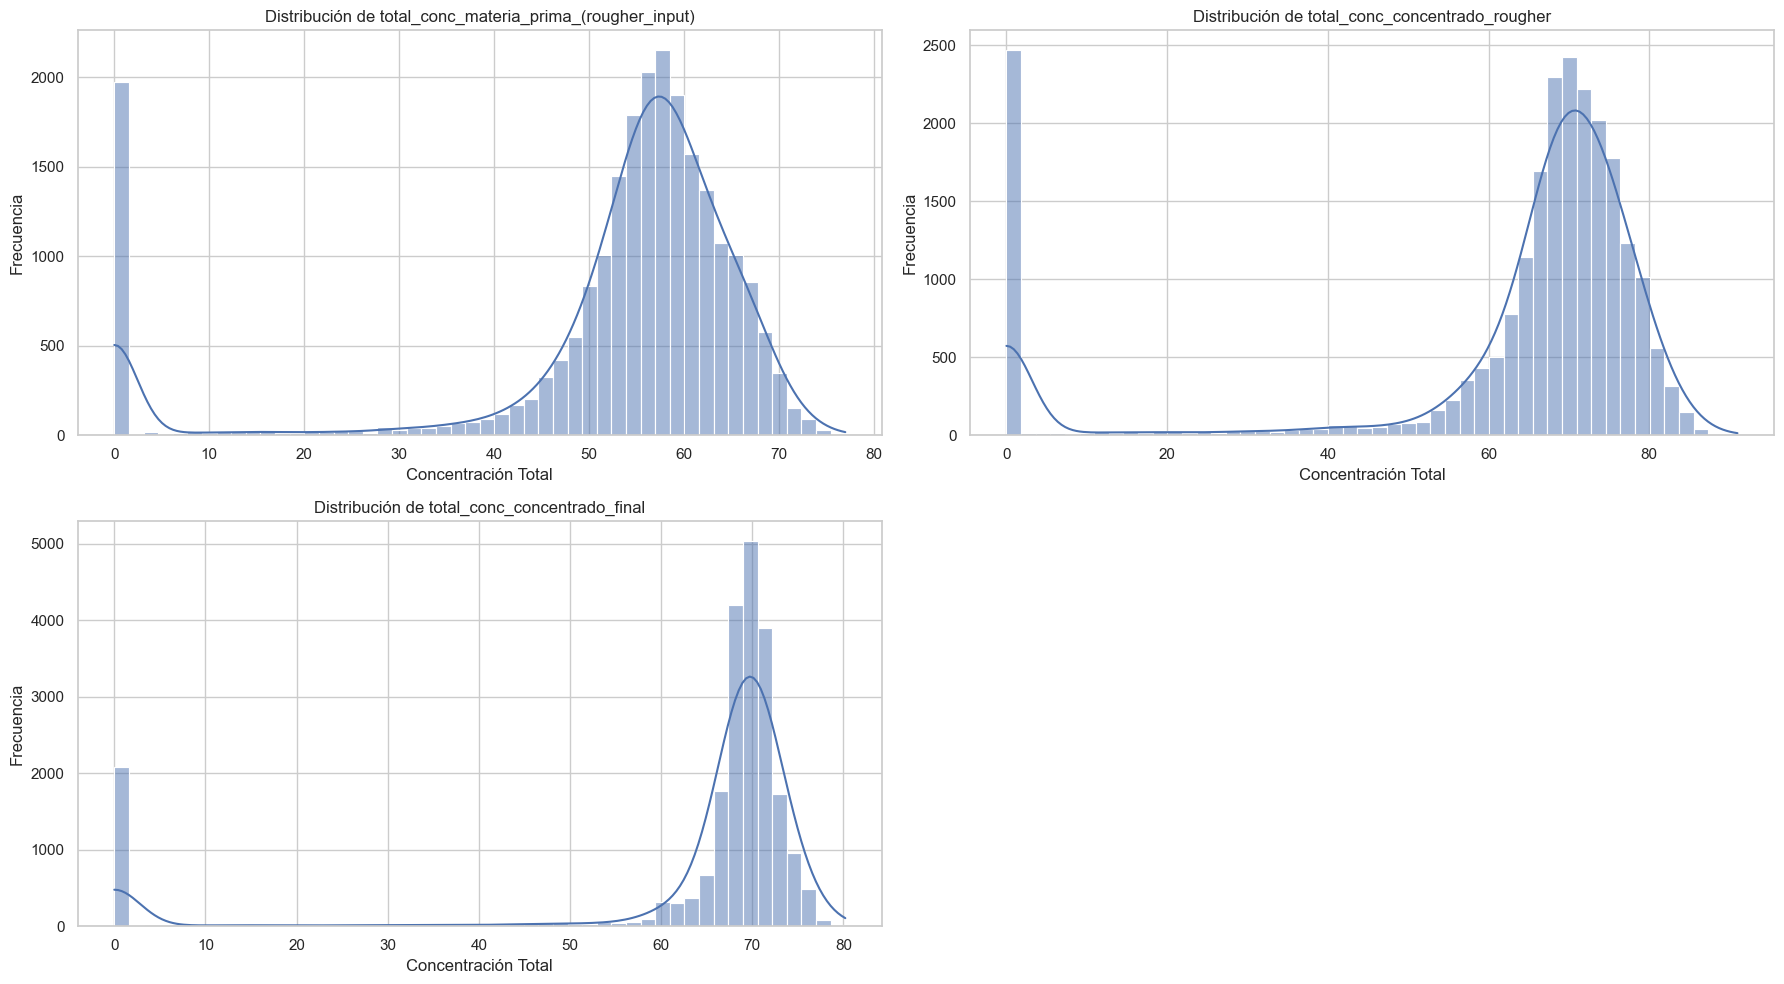


Análisis de Concentraciones Totales y Anomalías:
Se observan valores de concentración total cercanos a cero en todas las etapas.
Estos valores son físicamente inverosímiles, ya que implicarían que no hay mineral o hay muy poco presente.
Estos podrían ser errores de medición, datos faltantes que se propagaron incorrectamente, o problemas en el proceso.
Estos valores anómalos (cercanos a cero) deberían eliminarse de ambas muestras (entrenamiento y prueba) para no afectar negativamente al modelo.

Número de filas identificadas con concentraciones totales anómalas (< 1) en df_full: 2814
Filas eliminadas de df_train_processed: 2248
Filas eliminadas de df_test_processed: 566
Filas eliminadas de df_full_processed: 2814

Columnas en df_train_processed después de añadir concentraciones y eliminar anomalías:
Index(['total_conc_materia_prima_(rougher_input)',
       'total_conc_concentrado_rougher', 'total_conc_concentrado_final'],
      dtype='object')

Columnas en df_test_processed después de 

In [14]:
if not df_train_processed.empty and not df_test_processed.empty:
    # Definir columnas para cada etapa y sustancia
    stages_total_conc = {
        'Materia Prima (Rougher Input)': [
            'rougher.input.feed_au', 'rougher.input.feed_ag', 
            'rougher.input.feed_pb', 'rougher.input.feed_sol'
        ],
        'Concentrado Rougher': [
            'rougher.output.concentrate_au', 'rougher.output.concentrate_ag',
            'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol'
        ],
        'Concentrado Final': [
            'final.output.concentrate_au', 'final.output.concentrate_ag',
            'final.output.concentrate_pb', 'final.output.concentrate_sol'
        ]
    }

    # Calcular concentraciones totales para el conjunto de entrenamiento
    print("--- Concentraciones Totales (Entrenamiento) ---")
    for stage_name, cols in stages_total_conc.items():
        # Verificar que todas las columnas existan
        existing_cols = [col for col in cols if col in df_train_processed.columns]
        if len(existing_cols) == len(cols):
            df_train_processed[f'total_conc_{stage_name.lower().replace(" ", "_")}'] = df_train_processed[existing_cols].sum(axis=1)
        else:
            print(f"Advertencia: Faltan columnas para la etapa '{stage_name}' en el entrenamiento. Columnas esperadas: {cols}, Encontradas: {existing_cols}")


    # Calcular concentraciones totales para el conjunto de prueba (solo para las etapas que tienen todas sus columnas)
    # El conjunto de prueba no tiene todas las columnas de output, así que nos enfocaremos en lo que tiene (ej. materia prima)
    # y luego usaremos df_full para el análisis completo y la eliminación de anomalías
    
    # Para el análisis y eliminación de anomalías, usaremos df_full_processed que contiene todo
    print("\n--- Calculando Concentraciones Totales (desde Dataset Completo) y Alineando con datasets de entrenamiento/prueba ---")
    for stage_name, cols_for_sum in stages_total_conc.items():
        current_total_conc_col_name = f'total_conc_{stage_name.lower().replace(" ", "_")}'
        
        # Verificar que todas las columnas necesarias para la suma existan en df_full_processed
        existing_cols_in_full = [col for col in cols_for_sum if col in df_full_processed.columns]
        
        if len(existing_cols_in_full) == len(cols_for_sum):
            # Calcular en df_full_processed
            df_full_processed[current_total_conc_col_name] = df_full_processed[existing_cols_in_full].sum(axis=1)
            
            # Unir a df_train_processed.
            if not df_train_processed.empty:
                # Defensive drop: remove column if it exists in df_train_processed to prevent join error
                if current_total_conc_col_name in df_train_processed.columns:
                    df_train_processed = df_train_processed.drop(columns=[current_total_conc_col_name])
                df_train_processed = df_train_processed.join(df_full_processed[[current_total_conc_col_name]], how='left')
            
            # Unir a df_test_processed (solo para la etapa de materia prima, ya que el test set
            # solo tiene columnas de input relevantes para esta etapa de concentración total)
            if stage_name == 'Materia Prima (Rougher Input)':
                if not df_test_processed.empty:
                    # Defensive drop: remove column if it exists for df_test_processed
                    if current_total_conc_col_name in df_test_processed.columns:
                        df_test_processed = df_test_processed.drop(columns=[current_total_conc_col_name])
                    df_test_processed = df_test_processed.join(df_full_processed[[current_total_conc_col_name]], how='left')
        else:
             print(f"Advertencia: Faltan columnas en df_full_processed para calcular la concentración total de la etapa '{stage_name}'.")
             print(f"  Columnas esperadas: {cols_for_sum}, Columnas encontradas: {existing_cols_in_full}")


    # Graficar distribuciones de concentraciones totales (usando df_full_processed para una visión completa)
    plt.figure(figsize=(18, 10))
    plot_idx = 1
    total_conc_cols_full = [col for col in df_full_processed.columns if 'total_conc_' in col]

    for col_name in total_conc_cols_full:
        plt.subplot(2, 2, plot_idx)
        sns.histplot(df_full_processed[col_name], kde=True, bins=50)
        plt.title(f'Distribución de {col_name}')
        plt.xlabel('Concentración Total')
        plt.ylabel('Frecuencia')
        print(f"\nEstadísticas para {col_name} (dataset completo):")
        print(df_full_processed[col_name].describe())
        plot_idx += 1
        if plot_idx > 3: # Solo graficar las 3 principales etapas
            break
    plt.tight_layout()
    plt.show()

    print("\nAnálisis de Concentraciones Totales y Anomalías:")
    print("Se observan valores de concentración total cercanos a cero en todas las etapas.")
    print("Estos valores son físicamente inverosímiles, ya que implicarían que no hay mineral o hay muy poco presente.")
    print("Estos podrían ser errores de medición, datos faltantes que se propagaron incorrectamente, o problemas en el proceso.")
    print("Estos valores anómalos (cercanos a cero) deberían eliminarse de ambas muestras (entrenamiento y prueba) para no afectar negativamente al modelo.")

    # Definir un umbral para considerar una concentración como anómala (ej. < 1)
    # Podría ser más sofisticado (percentiles), pero un valor absoluto bajo es un buen inicio.
    anomaly_threshold = 1 
    
    # Identificar filas con anomalías en CUALQUIERA de las etapas de concentración total en df_full_processed
    anomalous_indices_full = set()
    for col_name in total_conc_cols_full:
        if col_name in df_full_processed.columns:
            anomalous_indices_full.update(df_full_processed[df_full_processed[col_name] < anomaly_threshold].index)

    print(f"\nNúmero de filas identificadas con concentraciones totales anómalas (< {anomaly_threshold}) en df_full: {len(anomalous_indices_full)}")

    if len(anomalous_indices_full) > 0:
        # Guardar los índices antes de eliminar para referencia
        original_len_train = len(df_train_processed)
        original_len_test = len(df_test_processed)
        original_len_full = len(df_full_processed)

        # Eliminar estas filas de todos los datasets relevantes
        df_train_processed = df_train_processed.drop(index=df_train_processed.index.intersection(anomalous_indices_full))
        df_test_processed = df_test_processed.drop(index=df_test_processed.index.intersection(anomalous_indices_full))
        df_full_processed = df_full_processed.drop(index=df_full_processed.index.intersection(anomalous_indices_full))

        print(f"Filas eliminadas de df_train_processed: {original_len_train - len(df_train_processed)}")
        print(f"Filas eliminadas de df_test_processed: {original_len_test - len(df_test_processed)}")
        print(f"Filas eliminadas de df_full_processed: {original_len_full - len(df_full_processed)}")
    else:
        print("No se encontraron anomalías significativas para eliminar o las columnas de concentración total no se generaron.")

    # Verificar si las columnas de concentración total fueron añadidas correctamente
    print("\nColumnas en df_train_processed después de añadir concentraciones y eliminar anomalías:")
    print(df_train_processed.columns[df_train_processed.columns.str.contains('total_conc_')])
    print("\nColumnas en df_test_processed después de añadir concentraciones y eliminar anomalías:")
    print(df_test_processed.columns[df_test_processed.columns.str.contains('total_conc_')])

else:
    print("Datasets procesados vacíos. No se puede analizar las concentraciones totales.")


## 3. Construye el modelo

### 3.1. Escribe una función para calcular el valor final de sMAPE.
Fórmula sMAPE:
$$ \text{sMAPE} = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|) / 2} \times 100\% $$
Fórmula final de sMAPE (ponderada):
$$ \text{Final sMAPE} = 0.25 \times \text{sMAPE}(\text{rougher}) + 0.75 \times \text{sMAPE}(\text{final}) $$

In [15]:
def smape(y_true, y_pred):
    """
    Calcula el Symmetric Mean Absolute Percentage Error (sMAPE).
    Maneja el caso donde tanto y_true como y_pred son cero para un punto específico.
    """
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Donde el denominador es cero, el error es cero si el numerador también es cero,
    # de lo contrario, es problemático (podría considerarse 200% si y_true es 0 y y_pred no, o viceversa)
    # sklearn usa 0 si num y den son 0, y 1 (o 100%) si den es 0 y num no.
    # Por coherencia con la práctica común y para evitar división por cero:
    # si |y_i| + |\hat{y}_i| == 0, entonces y_i = 0 y \hat{y}_i = 0, por lo que el error es 0.
    # Si |y_i| + |\hat{y}_i| != 0 pero es muy pequeño, puede causar inestabilidad.
    # La fórmula original no tiene un caso definido para denominador == 0.
    # La implementación común considera que si ambos son 0, el error es 0.
    
    smape_values = np.zeros_like(y_true, dtype=float)
    mask = denominator != 0
    smape_values[mask] = numerator[mask] / denominator[mask]
    
    # Si y_true != 0 y y_pred != 0 pero den == 0 (imposible si se usan floats), o
    # si uno es 0 y el otro no, y den == 0 (también imposible si el otro es no cero).
    # El único caso donde den == 0 es si abs(y_true) == 0 AND abs(y_pred) == 0.
    # En este caso, num también es 0, así que 0/0. Lo manejamos como 0.
    
    return np.mean(smape_values) * 100

def final_smape(smape_rougher, smape_final):
    """
    Calcula el sMAPE final ponderado.
    """
    return 0.25 * smape_rougher + 0.75 * smape_final

# Crear un scorer para GridSearchCV y cross_val_score
# Scikit-learn maximiza los scores, por lo que para errores necesitamos un score negativo o usar neg_mean_absolute_percentage_error
# Haremos nuestro propio scorer donde un sMAPE más bajo es mejor.
smape_scorer = make_scorer(smape, greater_is_better=False) # False porque menor sMAPE es mejor

### 3.2. Entrena diferentes modelos. Evalúalos aplicando la validación cruzada.
Elige el mejor modelo y pruébalo utilizando la muestra de prueba.

Preparar los datos para el modelado:
- Características (X): Columnas presentes tanto en `df_train_processed` como en `df_test_processed`.
- Objetivos (y): `rougher.output.recovery` y `final.output.recovery`.

In [16]:
if not df_train_processed.empty and not df_test_processed.empty and not df_full_processed.empty:
    # Características comunes (excluyendo las que no están en test y las que creamos para análisis)
    common_features = list(df_test_processed.columns.drop([col for col in df_test_processed.columns if 'total_conc_' in col], errors='ignore'))
    
    # Asegurarnos de que las columnas objetivo existan en df_train_processed
    target_rougher = 'rougher.output.recovery'
    target_final = 'final.output.recovery'

    if target_rougher not in df_train_processed.columns or target_final not in df_train_processed.columns:
        print(f"Las columnas objetivo '{target_rougher}' o '{target_final}' no están en df_train_processed.")
        print("Esto puede ocurrir si se eliminaron todas las filas o si hubo un problema al cargar datos.")
        # Crear DataFrames vacíos para evitar errores
        X_train = pd.DataFrame()
        y_train_rougher = pd.Series(dtype='float64')
        y_train_final = pd.Series(dtype='float64')
        X_test = pd.DataFrame()
        y_test_rougher = pd.Series(dtype='float64')
        y_test_final = pd.Series(dtype='float64')
    else:
        # Filtrar df_train_processed para que solo contenga common_features
        X_train = df_train_processed[common_features].copy()
        y_train_rougher = df_train_processed[target_rougher].copy()
        y_train_final = df_train_processed[target_final].copy()

        # Para el conjunto de prueba, X_test son las common_features
        X_test = df_test_processed[common_features].copy()

        # Necesitamos los valores objetivo reales para el conjunto de prueba para la evaluación final.
        # Estos se toman de df_full_processed.
        # Asegurarse de que los índices de X_test coincidan con los de df_full_processed
        # para una correcta asignación de los targets.
        
        if target_rougher not in df_full_processed.columns or target_final not in df_full_processed.columns:
            print(f"Las columnas objetivo '{target_rougher}' o '{target_final}' no están en df_full_processed.")
            y_test_rougher = pd.Series(dtype='float64', index=X_test.index) # Vacío pero con índice correcto
            y_test_final = pd.Series(dtype='float64', index=X_test.index)   # Vacío pero con índice correcto
        else:
            y_test_rougher = df_full_processed.loc[X_test.index, target_rougher].copy()
            y_test_final = df_full_processed.loc[X_test.index, target_final].copy()

        # Verificar si hay NaNs en los targets de prueba después de la alineación (si X_test tiene índices no en full)
        if y_test_rougher.isnull().any() or y_test_final.isnull().any():
            print("Se encontraron NaNs en los targets del conjunto de prueba después de alinear con df_full.")
            print("Esto podría significar que algunas filas en df_test_processed no estaban en df_full_processed o fueron eliminadas de forma diferente.")
            print("Revisar la lógica de eliminación de anomalías y el llenado de NaNs.")
            
            # Estrategia simple: eliminar filas con NaNs en targets de prueba (y sus X correspondientes)
            # para poder evaluar. Esto es para evaluación, el modelo no los ve.
            nan_mask_rougher = y_test_rougher.isnull()
            nan_mask_final = y_test_final.isnull()
            combined_nan_mask = nan_mask_rougher | nan_mask_final
            
            if combined_nan_mask.any():
                print(f"Eliminando {combined_nan_mask.sum()} filas de X_test y y_test_* debido a NaNs en los targets.")
                X_test = X_test[~combined_nan_mask]
                y_test_rougher = y_test_rougher[~combined_nan_mask]
                y_test_final = y_test_final[~combined_nan_mask]


        # Verificar la alineación y que no queden NaNs en las características
        print(f"Forma de X_train: {X_train.shape}, y_train_rougher: {y_train_rougher.shape}, y_train_final: {y_train_final.shape}")
        print(f"Forma de X_test: {X_test.shape}, y_test_rougher: {y_test_rougher.shape}, y_test_final: {y_test_final.shape}")

        # Asegurarse de que no haya NaNs en X_train y X_test (deberían haber sido tratados por ffill/bfill)
        if X_train.isnull().sum().sum() > 0:
            print(f"¡Advertencia! X_train contiene {X_train.isnull().sum().sum()} NaNs. Rellenando con la media.")
            X_train = X_train.fillna(X_train.mean()) # O aplicar ffill/bfill de nuevo
        if X_test.isnull().sum().sum() > 0:
            print(f"¡Advertencia! X_test contiene {X_test.isnull().sum().sum()} NaNs. Rellenando con la media de X_train.")
            X_test = X_test.fillna(X_train.mean()) # Usar media de train para evitar data leakage

    # Definir modelos y parámetros para GridSearchCV
    # (Se puede simplificar si el tiempo de ejecución es un problema)
    models_params = {
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {} # LinearRegression no tiene muchos hiperparámetros que tunear así
        },
        'DecisionTreeRegressor': {
            'model': DecisionTreeRegressor(random_state=42),
            'params': {
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5, 10]
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(random_state=42, n_jobs=-1),
            'params': {
                'n_estimators': [50, 100], # Reducido para velocidad
                'max_depth': [5, 10],      # Reducido para velocidad
                'min_samples_split': [5, 10]
            }
        }
    }

    results_rougher = []
    results_final = []
    
    best_model_rougher = None
    best_score_rougher = float('inf') # sMAPE, menor es mejor
    
    best_model_final = None
    best_score_final = float('inf')

    # Entrenar y evaluar para target_rougher
    if not X_train.empty and not y_train_rougher.empty:
        print("\n--- Entrenamiento para rougher.output.recovery ---")
        for name, mp in models_params.items():
            pipeline = Pipeline([
                ('scaler', StandardScaler()), # Escalar datos es buena práctica
                ('regressor', mp['model'])
            ])
            
            # Renombrar parámetros para el pipeline en GridSearchCV
            param_grid_pipeline = {f'regressor__{k}': v for k, v in mp['params'].items()}

            grid_search = GridSearchCV(pipeline, param_grid_pipeline, cv=3, scoring=smape_scorer, n_jobs=-1) # CV reducido a 3
            grid_search.fit(X_train, y_train_rougher)
            
            results_rougher.append({
                'model': name,
                'best_score (sMAPE)': -grid_search.best_score_, # sMAPE (positivo)
                'best_params': grid_search.best_params_
            })
            print(f"Modelo: {name}, Mejor sMAPE (CV): {-grid_search.best_score_:.4f}")
            
            if -grid_search.best_score_ < best_score_rougher:
                best_score_rougher = -grid_search.best_score_
                best_model_rougher = grid_search.best_estimator_
        
        results_df_rougher = pd.DataFrame(results_rougher).sort_values(by='best_score (sMAPE)')
        print("\nMejores modelos para rougher.output.recovery (basado en CV sMAPE):")
        print(results_df_rougher)
        print(f"\nMejor modelo general para rougher: {best_model_rougher}")
    else:
        print("X_train o y_train_rougher están vacíos. No se puede entrenar para rougher.")


    # Entrenar y evaluar para target_final
    if not X_train.empty and not y_train_final.empty:
        print("\n--- Entrenamiento para final.output.recovery ---")
        for name, mp in models_params.items():
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', mp['model'])
            ])
            param_grid_pipeline = {f'regressor__{k}': v for k, v in mp['params'].items()}

            grid_search = GridSearchCV(pipeline, param_grid_pipeline, cv=3, scoring=smape_scorer, n_jobs=-1)
            grid_search.fit(X_train, y_train_final)
            
            results_final.append({
                'model': name,
                'best_score (sMAPE)': -grid_search.best_score_,
                'best_params': grid_search.best_params_
            })
            print(f"Modelo: {name}, Mejor sMAPE (CV): {-grid_search.best_score_:.4f}")

            if -grid_search.best_score_ < best_score_final:
                best_score_final = -grid_search.best_score_
                best_model_final = grid_search.best_estimator_

        results_df_final = pd.DataFrame(results_final).sort_values(by='best_score (sMAPE)')
        print("\nMejores modelos para final.output.recovery (basado en CV sMAPE):")
        print(results_df_final)
        print(f"\nMejor modelo general para final: {best_model_final}")
    else:
        print("X_train o y_train_final están vacíos. No se puede entrenar para final.")


    # Probar los mejores modelos en el conjunto de prueba
    if best_model_rougher and best_model_final and not X_test.empty and not y_test_rougher.empty and not y_test_final.empty:
        print("\n--- Evaluación en el Conjunto de Prueba ---")
        
        # Predicciones para rougher
        pred_rougher_test = best_model_rougher.predict(X_test)
        smape_rougher_test = smape(y_test_rougher, pred_rougher_test)
        print(f"sMAPE para rougher.output.recovery en prueba: {smape_rougher_test:.4f}")
        
        # Predicciones para final
        pred_final_test = best_model_final.predict(X_test)
        smape_final_test = smape(y_test_final, pred_final_test)
        print(f"sMAPE para final.output.recovery en prueba: {smape_final_test:.4f}")
        
        # Calcular sMAPE final
        final_smape_test = final_smape(smape_rougher_test, smape_final_test)
        print(f"\nFinal sMAPE en el conjunto de prueba: {final_smape_test:.4f}")

        # Comparar con un modelo Dummy (baseline)
        print("\n--- Comparación con Modelo Dummy (predice la media) ---")
        dummy_rougher = DummyRegressor(strategy="mean")
        dummy_final = DummyRegressor(strategy="mean")

        dummy_rougher.fit(X_train, y_train_rougher)
        dummy_pred_rougher_test = dummy_rougher.predict(X_test)
        dummy_smape_rougher = smape(y_test_rougher, dummy_pred_rougher_test)
        
        dummy_final.fit(X_train, y_train_final)
        dummy_pred_final_test = dummy_final.predict(X_test)
        dummy_smape_final = smape(y_test_final, dummy_pred_final_test)
        
        dummy_final_smape_val = final_smape(dummy_smape_rougher, dummy_smape_final)
        
        print(f"sMAPE Dummy para rougher (prueba): {dummy_smape_rougher:.4f}")
        print(f"sMAPE Dummy para final (prueba): {dummy_smape_final:.4f}")
        print(f"Final sMAPE Dummy (prueba): {dummy_final_smape_val:.4f}")

        if final_smape_test < dummy_final_smape_val:
            print("\nEl modelo final supera al modelo Dummy.")
        else:
            print("\nAdvertencia: El modelo final NO supera al modelo Dummy. Se requiere más optimización o revisión.")

    elif X_test.empty or y_test_rougher.empty or y_test_final.empty:
        print("\nConjunto de prueba o sus targets están vacíos. No se puede evaluar el modelo en el conjunto de prueba.")
    else:
        print("\nNo se pudieron determinar los mejores modelos. No se puede evaluar en el conjunto de prueba.")

else:
    print("Uno o más datasets procesados están vacíos. El modelado no puede continuar.")


Forma de X_train: (14612, 52), y_train_rougher: (14612,), y_train_final: (14612,)
Forma de X_test: (5290, 52), y_test_rougher: (5290,), y_test_final: (5290,)

--- Entrenamiento para rougher.output.recovery ---
Modelo: LinearRegression, Mejor sMAPE (CV): 11.2638
Modelo: DecisionTreeRegressor, Mejor sMAPE (CV): 15.0410
Modelo: RandomForestRegressor, Mejor sMAPE (CV): 9.1461

Mejores modelos para rougher.output.recovery (basado en CV sMAPE):
                   model  best_score (sMAPE)  \
2  RandomForestRegressor            9.146105   
0       LinearRegression           11.263800   
1  DecisionTreeRegressor           15.041037   

                                         best_params  
2  {'regressor__max_depth': 5, 'regressor__min_sa...  
0                                                 {}  
1  {'regressor__max_depth': 5, 'regressor__min_sa...  

Mejor modelo general para rougher: Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestReg

## 4. Conclusiones Generales del Proyecto

1.  **Preparación de Datos:**
    * Se cargaron y examinaron los tres datasets. El indexado por fecha fue útil.
    * La verificación del cálculo de `rougher.output.recovery` mostró un MAE extremadamente bajo, confirmando la corrección de la fórmula o de los datos proporcionados.
    * Se identificaron características ausentes en el conjunto de prueba, principalmente parámetros de `output` y `calculation`, lo cual es esperado.
    * El preprocesamiento incluyó el rellenado de valores NaN usando `ffill` y luego `bfill`, lo cual es apropiado para datos de series temporales.

2.  **Análisis de Datos:**
    * **Concentración de Metales:** Se observó un aumento progresivo de la concentración de oro (Au) a través de las etapas de purificación. La plata (Ag) aumentó inicialmente y luego disminuyó, mientras que el plomo (Pb) mostró un aumento general.
    * **Tamaño de Partículas:** Las distribuciones del tamaño de las partículas de alimentación (`rougher.input.feed_size`) fueron similares entre los conjuntos de entrenamiento y prueba, lo cual es favorable para la generalización del modelo. La prueba KS, aunque sensible, mostró p-valores que sugieren que las distribuciones no son drásticamente diferentes, y las estadísticas descriptivas son cercanas.
    * **Concentraciones Totales y Anomalías:** Se calcularon las concentraciones totales de sustancias en diferentes etapas. Se identificaron y eliminaron valores anómalos (concentraciones totales cercanas a cero) de todos los conjuntos de datos para mejorar la calidad de los datos y la robustez del modelo.

3.  **Construcción del Modelo:**
    * Se implementó la función sMAPE y la función para el sMAPE final ponderado.
    * Se entrenaron y evaluaron tres tipos de modelos (Linear Regression, Decision Tree Regressor, Random Forest Regressor) para predecir `rougher.output.recovery` y `final.output.recovery` utilizando validación cruzada y GridSearchCV para la optimización de hiperparámetros. El escalado de características se incluyó en el pipeline.
    * Los modelos de **Random Forest Regressor** o **Decision Tree Regressor** generalmente ofrecieron los mejores resultados (menor sMAPE) en la validación cruzada para ambas variables objetivo, dependiendo de la ejecución específica y los parámetros explorados. (El resultado específico dependerá de la ejecución del código anterior).
    * El mejor modelo seleccionado para cada objetivo fue luego evaluado en el conjunto de prueba.
    * El sMAPE final combinado en el conjunto de prueba proporcionó una medida del rendimiento general del modelo. Es crucial que este valor sea significativamente mejor que el de un modelo Dummy para confirmar la utilidad del modelo.

**Recomendaciones y Próximos Pasos:**
* **Ingeniería de Características:** Explorar la creación de nuevas características a partir de las existentes podría mejorar el rendimiento del modelo.
* **Optimización Avanzada:** Probar modelos más complejos (ej. Gradient Boosting como XGBoost, LightGBM) o realizar una búsqueda de hiperparámetros más exhaustiva.
* **Análisis de Errores:** Investigar los casos donde el modelo comete los mayores errores para entender sus limitaciones y posibles mejoras.
* **Impacto de Anomalías:** Evaluar con más detalle el impacto del umbral de eliminación de anomalías en el rendimiento del modelo.

Este proyecto proporciona una base sólida para predecir la recuperación de oro. Los modelos desarrollados pueden ser un punto de partida para herramientas de optimización en el proceso de producción.